In [ ]:
# develop-translation-operator.ipynb
#
# Bryan Daniels
# 2023/9/26
#
# Using the continuous dynamics developed in 'initial-model-brainstorming', create
# a translation operator that can move the edge attractor along the attractor manifold.
#

In [2]:
import simpleNeuralModel
import numpy as np
import scipy.stats
import tqdm
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

In [3]:
def gaussian_kernel_matrix(N,width,normed=True):
    """
    Interaction matrix with Gaussian kernel.
    
    N:       total number of units.  Returned interaction matrix will have shape (N,N)
    width:   width of the Gaussian measured in number of units
    """
    mat = [ scipy.stats.distributions.norm.pdf(range(N),loc=i,scale=width) for i in range(N) ]
    if normed:
        mat = [ row/np.sum(row) for row in mat ]
    return np.array(mat)

In [105]:
def interpolated_state(rates_series,k=1):
    """
    Takes a pandas Series (or simple list) of rates or states along the 1D line of neurons.
    Returns the scipy.interpolate.PPoly function object representing an interpolated spline.
    """
    tck = scipy.interpolate.splrep(range(len(rates_series)),rates_series,k=k)
    ppoly = scipy.interpolate.PPoly.from_spline(tck)
    return ppoly

In [91]:
def find_edge_location(rates_series,k=1):
    """
    Takes a pandas Series (or simple list) of rates or states along the 1D line of neurons.
    Returns the (interpolated) location of the zero crossing.
    """
    ppoly = interpolated_state(rates_series,k=k)
    return ppoly.roots()

In [101]:
interp = interpolated_state(fp_list[20])

In [110]:
interp([3,4,4.5,5,5.5,6,7])

array([101.98119474, 101.96717361,  51.9590477 ,   1.95092179,
         1.94354064,   1.9361595 ,   1.9256096 ])

In [186]:
class laplace_network:
    
    def __init__(self,N,J=1,kernel_width=2,boundary_input=100,num_inputs=5):
        """
        N              : number of units
        J              : scale of interaction strength among nearby neighbors
        kernel_width   : width of Gaussian kernel for interactions
        boundary_input : field setting boundary conditions (positive on left end and negative on right end)
        num_inputs     : number of fixed input nodes at each end
        """
        self.N = N
        self.J = J
        self.kernel_width = kernel_width
        self.boundary_input = boundary_input
        self.num_inputs = num_inputs
        
        # set interaction matrix
        self.Jmat = J * gaussian_kernel_matrix(N,kernel_width)
        
        # set external inputs
        inputExt = np.zeros(N)
        inputExt[0:num_inputs] = boundary_input
        inputExt[-num_inputs:] = -boundary_input
        self.inputExt = inputExt
        
    def find_edge_state(self,center,method='translate'):
        """
        Find stationary state (fixed point) that looks like an edge at the given location

        center                    : desired center location of edge
        method ('translate')      : If 'translate', first find the edge fixed point numerically 
                                    in the middle of the network, then interpolate and translate
                                    to the desired position.  Can be more numerically stable when
                                    taking derivatives.
                                    If 'minimize', find the edge fixed point numerically directly
                                    at the desired position.
        
        """
        if method=='minimize':
            initial_location = center
        elif method=='translate':
            initial_location = self.N/2
        else:
            raise Exception('Unrecognized method: {}'.format(method))
        
        # find edge state numerically
        # TO DO: should the edge width be equal to the kernel width? (seems to work...)
        width = self.kernel_width
        initialGuessState = -(np.arange(0,N)-initial_location)/width
        initialGuessRates = np.tanh(initialGuessState)
        fp_initial = simpleNeuralModel.findFixedPoint(self.Jmat,initialGuessState,inputExt=self.inputExt)
        
        # if requested, move the edge to the desired location
        if method=='translate':
            # start by keeping the states of the end inputs plus padding of 2*kernel_width fixed, 
            # and with saturated left and right states everywhere else around the desired center
            fp = fp_initial.copy()
            fixed_end_width = self.num_inputs + int(np.ceil(2*self.kernel_width))
            left_state,right_state = fp_initial[fixed_end_width],fp_initial[-fixed_end_width-1]
            fp[fixed_end_width:int(center)] = left_state
            fp[int(center):-fixed_end_width] = right_state
            
            # now interpolate the states around the initial edge and paste this in the new location
            initial_actual_location = find_edge_location(fp_initial)[0]
            shift = center - initial_actual_location
            fp_initial_spline = interpolated_state(fp_initial)
            # set up range of locations that will be overwritten
            n_min = max(fixed_end_width,int(np.ceil(fixed_end_width+shift)))
            n_max = min(self.N-fixed_end_width,int(np.floor(self.N-fixed_end_width+shift)))
            n_vals = range(n_min,n_max)
            # overwrite with the shifted edge
            fp[n_vals] = fp_initial_spline(n_vals-shift)
        else:
            fp = fp_initial
        
        return fp
    
    def simulate_dynamics(self,initial_state,t_final,noise_var,additional_input=None,seed=None,delta_t=0.001):
        """
        Use simpleNeuralModel.simpleNeuralDynamics to simulate the network's dynamics.

        additional_input (None)      : If given a list of length N, add this to the existing 
                                         external current as a constant input.
                                       If given an array of shape (# timepoints)x(N), add this
                                         to the existing external current as an input that
                                         varies over time.  (# timepoints = t_final/delta_t)
        seed (None)                  : If given, set random seed before running
        """
        num_timepoints = t_final/delta_t
        if additional_input is not None:
            if np.shape(additional_input) == (N,):
                total_input = self.inputExt + additional_input
            elif np.shape(additional_input) == (num_timepoints,N):
                total_input = [ self.inputExt + a for a in additional_input ]
            else:
                raise Exception("Unrecognized form of additional_input")
        else:
            total_input = self.inputExt
        
        if seed is not None:
            np.random.seed(seed)

        return simpleNeuralModel.simpleNeuralDynamics(self.Jmat,
                                                      total_input,
                                                      noiseVar=noise_var,
                                                      tFinal=t_final,
                                                      initialState=initial_state,
                                                      deltat=delta_t)

In [187]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

N = 50 # number of units
J = 2 # constant interaction strength between neighbors

net = laplace_network(N,J)

In [188]:
# find stationary states (fixed points) that look like an edge
center_list = range(0,N,2)
fp_list = []
for center in center_list:
    fp = net.find_edge_state(center,method='translate')#method='minimize')
    fp_list.append(fp)

In [189]:
# find stationary states (fixed points) that look like an edge using alternate method
center_list = range(0,N,2)
fp_list_minimize = []
for center in center_list:
    fp = net.find_edge_state(center,method='minimize')
    fp_list_minimize.append(fp)

In [190]:
# translation input should just be (proportional to) the derivative of edge fixed points
# with respect to position
translation_input_list = np.diff(fp_list,axis=0)

(-2.45, 51.45, -4.0, 4.0)

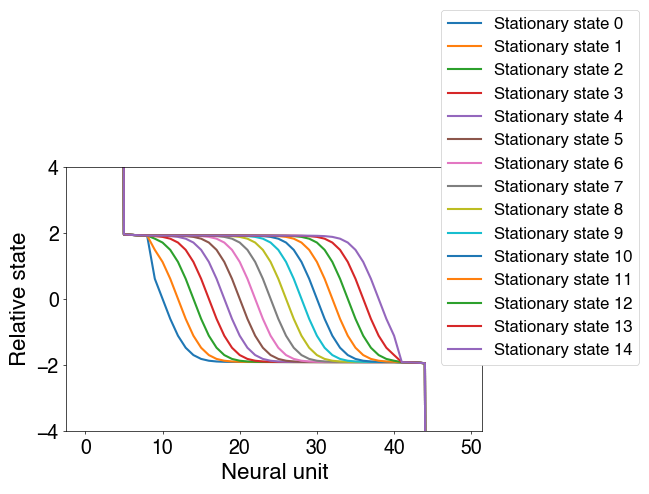

In [191]:
for i,fp in enumerate(fp_list[5:20]):
    plt.plot(fp,label='Stationary state {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Relative state')
leg = plt.legend(loc=(0.9,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-4,ymax=+4)

(-2.45, 51.45, -4.0, 4.0)

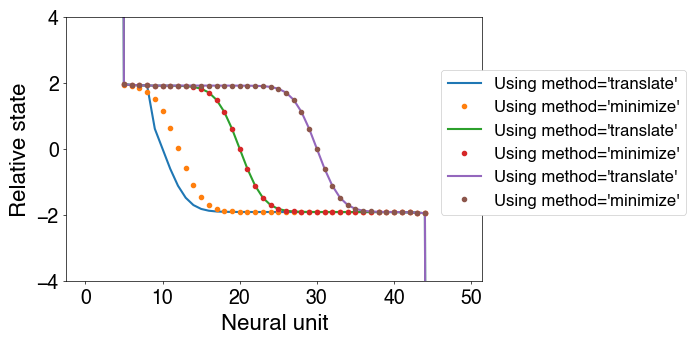

In [192]:
# compare edges found using method='translate' and method='minimize'
for fp,fp_minimize in zip(fp_list[5:20][::5],fp_list_minimize[5:20][::5]):
    plt.plot(fp,label="Using method='translate'")
    plt.plot(fp_minimize,'.',label="Using method='minimize'")
plt.xlabel('Neural unit')
plt.ylabel('Relative state')
leg = plt.legend(loc=(0.9,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-4,ymax=+4)

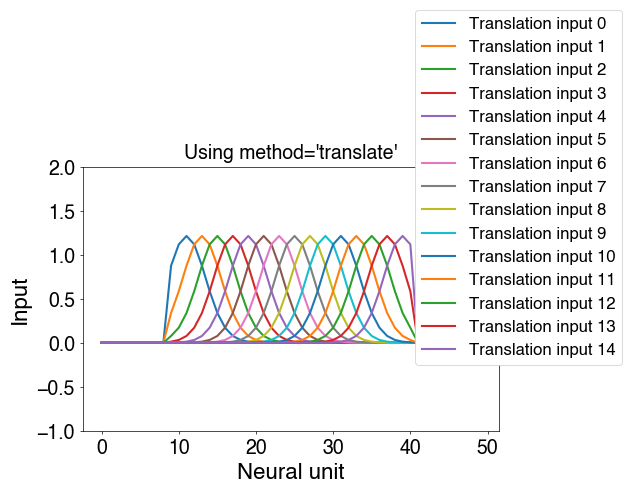

In [193]:
for i,trans_input in enumerate(translation_input_list[5:20]):
    plt.plot(trans_input,label='Translation input {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Input')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-1,ymax=+2)
plt.title("Using method='translate'");

# are these simply gaussian?
#plt.plot(range(N),6*scipy.stats.distributions.norm.pdf(range(N),loc=25,scale=net.kernel_width),lw=5)

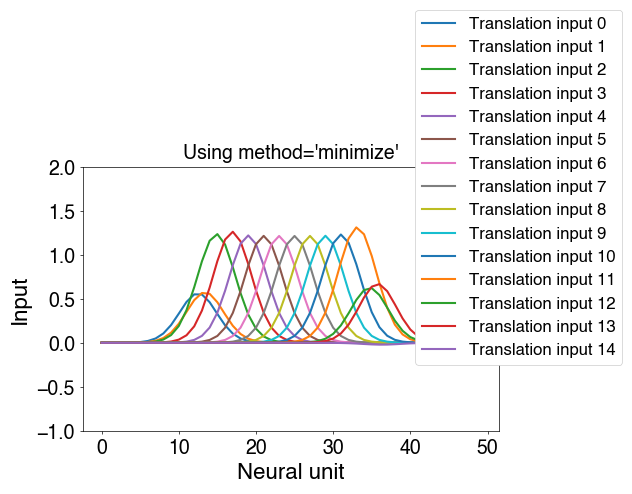

In [194]:
# using method='minimize'
translation_input_list_minimize = np.diff(fp_list_minimize,axis=0)
for i,trans_input in enumerate(translation_input_list_minimize[5:20]):
    plt.plot(trans_input,label='Translation input {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Input')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-1,ymax=+2)
plt.title("Using method='minimize'");

# 2023/9/28 Can we move an edge at constant velocity?

In [94]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
t_final = 50 #100 #20
delta_t = 0.001 #0.001
input_times = np.arange(0,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply input corresponding to moving delta_n in 1 unit of time
# delta_n = -1 #10 #0.5 # in units of number of neurons
# edge_state_new = net.find_edge_state(center + delta_n)
# translation_input = edge_state_new - edge_state

# apply time-varying input
# goal: move delta_n per unit of time
translation_input_time_varying = []
delta_n = 0.5
edge_state_old = edge_state.copy()
for t in range(t_final):
    # we will only change the input once every time unit
    delta_n_total = delta_n*(t+1)
    edge_state_new = net.find_edge_state(center + delta_n_total)
    translation_input = edge_state_new - edge_state_old
    for t_micro in range(int(1./delta_t)):
        translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()

# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
rates = np.tanh(states)

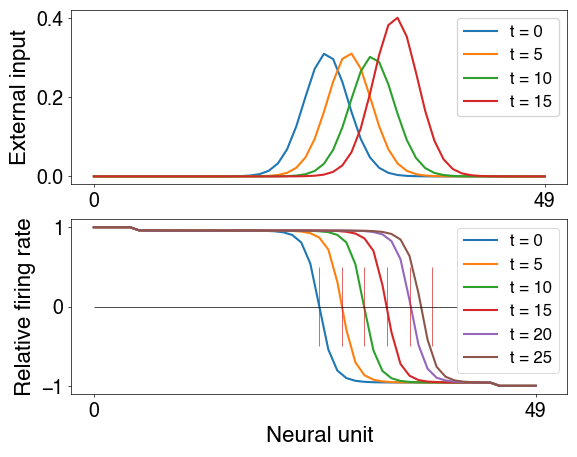

In [123]:
# input plot
plt.subplot(2,1,1)
for t in range(0,20,5):
    plt.plot(translation_input_time_varying[int(t/delta_t)],label='t = {}'.format(t))
leg = plt.legend()
plt.xticks(ticks=[0,N-1],labels=[0,N-1])
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for t in range(0,30,5):
    plt.plot(rates.loc[t],label="t = {}".format(t))
    plt.vlines([center+delta_n*t],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
plt.savefig('230928_move_edge_constant_velocity.pdf')

# 2023/10/17 Speed decaying in time

In [10]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_final = 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(0,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply input corresponding to moving delta_n in 1 unit of time
# delta_n = -1 #10 #0.5 # in units of number of neurons
# edge_state_new = net.find_edge_state(center + delta_n)
# translation_input = edge_state_new - edge_state

# apply time-varying input
# goal: move delta_n per unit of time
# translation_input_time_varying = []
# delta_n = 0.5
# edge_state_old = edge_state.copy()
# for t in range(t_final):
#     # we will only change the input once every time unit
#     delta_n_total = delta_n*(t+1)
#     edge_state_new = net.find_edge_state(center + delta_n_total)
#     translation_input = edge_state_new - edge_state_old
#     for t_micro in range(int(1./delta_t)):
#         translation_input_time_varying.append(translation_input)
#     edge_state_old = edge_state_new.copy()

# apply time-varying input that decays in time
# goal: move delta_n/t per unit of time
# (see notes 2023/10/17)
translation_input_time_varying = []
delta_n = 0.5
edge_state_old = edge_state.copy()
for i in range(i_final):
    # we will only change the input once every 2^i time units
    # (the first timestep is different)
    if i > 0:
        delta_t_step = 2**(i-1)
    elif i == 0:
        delta_t_step = 1
    delta_n_total = 1 + delta_n*i
    edge_state_new = net.find_edge_state(center + delta_n_total)
    translation_input = (edge_state_new - edge_state_old)/delta_t_step
    for t_micro in range(int(delta_t_step/delta_t)):
        translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
rates = np.tanh(states)

In [11]:
len(rates)

16001

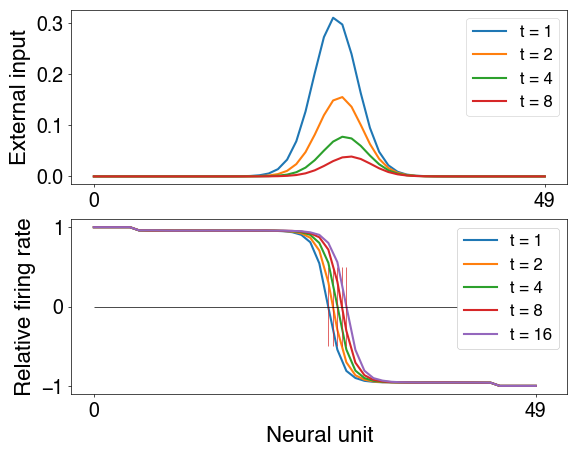

In [27]:
# input plot
plt.subplot(2,1,1)
i_list = list(range(i_final))
times = [2**i for i in i_list] #[0,1,2,4,8]
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)],label='t = {}'.format(t))
leg = plt.legend()
plt.xticks(ticks=[0,N-1],labels=[0,N-1])
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for i,t in zip(i_list,times):
    plt.plot(rates.loc[t],label="t = {}".format(t))
    plt.vlines([center + 1 + delta_n*i],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('230928_move_edge_constant_velocity.pdf')

Text(0, 0.5, 'Edge location')

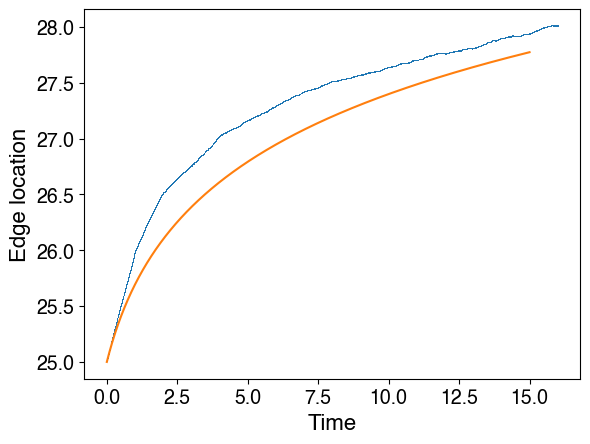

In [84]:
plt.plot(rates.index,[find_edge_location(rates.loc[i]) for i in rates.index],',')
plt.plot(rates.index[1000:]-1,25+np.log(rates.index[1000:]))
plt.xlabel('Time')
plt.ylabel('Edge location')

# 2023/10/18 Try again with continuously varying input

In [203]:
fp1 = net.find_edge_state(25)
fp2 = net.find_edge_state(25.0001)

In [204]:
fp1_min = net.find_edge_state(25,method='minimize')
fp2_min = net.find_edge_state(25.0001,method='minimize')

In [209]:
fp2_big_step = net.find_edge_state(26)

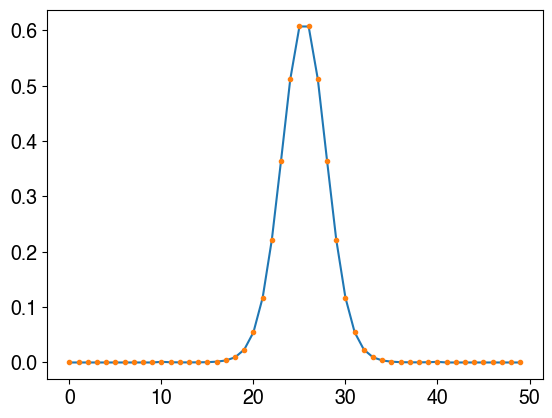

In [213]:
plt.plot((fp2-fp1)*10000)
plt.plot((fp2_big_step-fp1),'.')
#plt.plot((fp2_min-fp1_min)*10000)

(-2.45, 51.45, -2.0, 2.0)

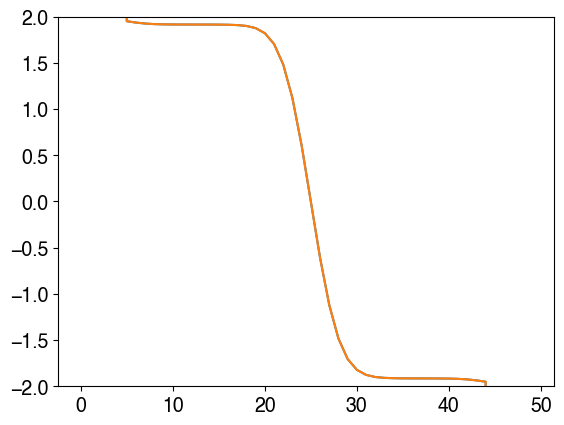

In [206]:
plt.plot(fp1)
plt.plot(fp1_min)
plt.axis(ymin=-2,ymax=+2)

(-2.45, 51.45, -2.0, 2.0)

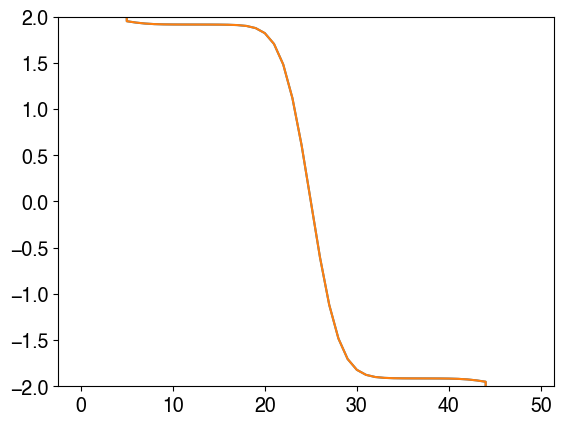

In [207]:
plt.plot(fp2)
plt.plot(fp2_min)
plt.axis(ymin=-2,ymax=+2)

In [241]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_start = 1. #0.5 #1.
t_final = t_start + 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(t_start,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply time-varying input that decays in time
# goal: move 1/t per unit of time

translation_input_time_varying = []

edge_state_old = edge_state.copy()
for t in input_times:
    n = center + np.log(t)
    edge_state_new = net.find_edge_state(n)
    translation_input = (edge_state_new - edge_state_old)/delta_t
    translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_start,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_start
rates = np.tanh(states)

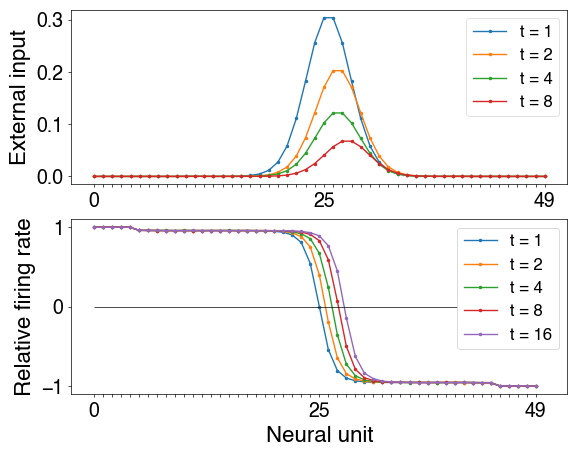

In [282]:
# input plot
plt.subplot(2,1,1)
i_list = list(range(i_final))
times = [2**i for i in i_list] #[0,1,2,4,8]
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)],'.-',label='t = {}'.format(t),lw=1,ms=3)
leg = plt.legend()
labels=['' for i in range(N)]
labeled_n = [0,int(N/2),N-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(N),labels=labels)
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for i,t in zip(i_list,times):
    plt.plot(rates.loc[t],'.-',label="t = {}".format(t),lw=1,ms=3)
    #plt.vlines([center + 2/3*i],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
labels=['' for i in range(N)]
labeled_n = [0,int(N/2),N-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(N),labels=labels)
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('230928_move_edge_constant_velocity.pdf')

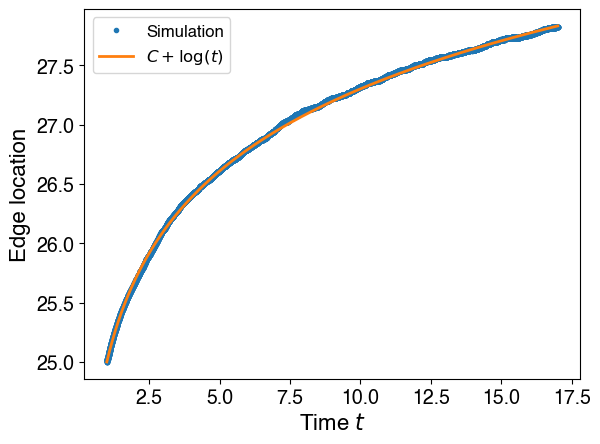

In [284]:
plt.plot(rates.index,[find_edge_location(rates.loc[i]) for i in rates.index],'.',label='Simulation')
plt.plot(rates.index,center+np.log(rates.index),label='$C+ \log(t)$',lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Edge location')
plt.legend()

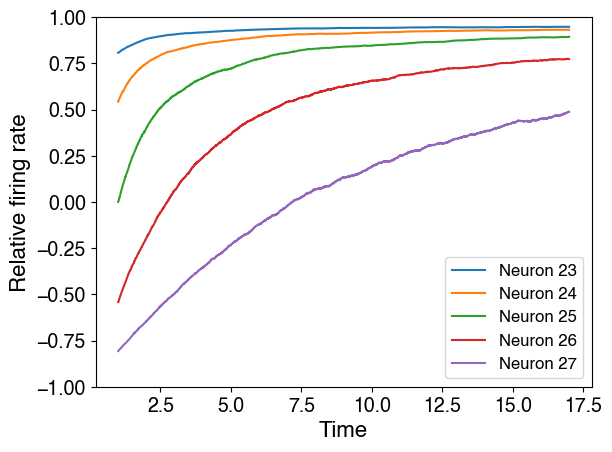

In [264]:
# plot rate over time for a particular neuron
neuron_indices = [23,24,25,26,27]
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(rates[name],label=name)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative firing rate')
plt.axis(ymin=-1,ymax=1);